**here, I use the Amazon Fine Food Reviews data (https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/amazon-fine-food-reviews.zip) to**  
    **1. build a classifier that predicts 5 star vs 1-4 star ratings**  
    **2. build a generative model to create 5 star review text **

the work is mostly based on these resources:  

https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/  
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/  
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [1]:
%pylab
%matplotlib inline
import pandas as pd
import seaborn as sns
import nltk
import string
import os
import re
from __future__ import division, print_function
sns.set_style('white')

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# importing and basic preprocessing

In [2]:
from keras.models import Sequential
from keras.layers.noise import GaussianNoise
from keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
reviews = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')

from https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/amazon-fine-food-reviews.zip

In [4]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
reviews.Score.unique()

array([5, 1, 4, 2, 3])

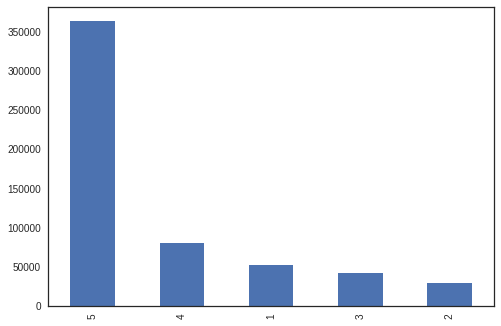

In [7]:
reviews.Score.value_counts().plot(kind = 'bar')

# LSTM models for review classification and generation

In [8]:
%%time

seq_length = 500 #padding/cut to this length
num_samples = 70000
texts = reviews.iloc[:num_samples].Text
#remove html line breaks
text = array([re.sub('<[^<]+?>', '', x) for x in texts])

#labels = reviews.iloc[:50000].Score-1 
labels = reviews.Score.apply(lambda x: x>4).iloc[:num_samples] #shift to start counting with 0

tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen= seq_length)

labels = labels.astype(int)
#labels = to_categorical(np.asarray(labels), num_classes= 5)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.1 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print("fraction 5 star in sample: ", sum(labels)/num_samples)
print("fraction 5 star in test set: ", mean(y_val))

Found 51014 unique tokens.
Shape of data tensor: (70000, 500)
Shape of label tensor: (70000,)
fraction 5 star in sample:  0.626157142857
fraction 5 star in test set:  0.630571428571
CPU times: user 7.98 s, sys: 179 ms, total: 8.16 s
Wall time: 8.11 s


In [9]:
data[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### GloVe embedding

GloVe from https://nlp.stanford.edu/projects/glove/

In [10]:
embeddings_index = {}
f = open(os.path.join('glove.6B/', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


embedding matrix

In [11]:
EMBEDDING_DIM = 100 #given GloVe fileb
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [12]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length = seq_length,
                            trainable=True,
                            )

### build the model

In [13]:
# create the model
embedding_vecor_length = 32
model = Sequential()
#model.add(embedding_layer)
model.add(Embedding(10000, embedding_vecor_length, input_length = data.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 405,665.0
Trainable params: 405,665.0
Non-trainable params: 0.0
________________________________________________________________

## ideas for improvement

- different embedding (GloVe didn't seem to help)
- more layers
- different architecture (Conv1D did not give better results)
- hyperparameters
- ...?

# generate review text

generate data (only 5 star reviews)

In [14]:
%%time

text = reviews[reviews.Score == 5].iloc[:5000].Text
# periods as words
#text = array([string.replace(x, '.', " .") for x in text])

#remove html line breaks
text = array([re.sub('<[^<]+?>', '', x) for x in text])

num_words = 800
tokenizer = Tokenizer(num_words = num_words, filters='!"#$%&()*+,.-/:;<=>?@[\\]^_`{|}~\t\n)')
tokenizer.fit_on_texts(text)
concat_text = tokenizer.texts_to_sequences(text)
concat_text = array([item for sublist in concat_text for item in sublist])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# for later text generation: int->word dictionary
inv_word_index = {v: k for k, v in word_index.iteritems()}

## training sequences of length 5
seq_length = 6
dataX = []
dataY = []
for i in range(0, len(concat_text) - seq_length, 1):
    seq_in = concat_text[i:i + seq_length]
    seq_out = concat_text[i + seq_length]
    dataX.append(seq_in)
    dataY.append(seq_out)
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Found 13978 unique tokens.
Total Patterns:  289056
CPU times: user 857 ms, sys: 46.7 ms, total: 904 ms
Wall time: 858 ms


### GloVe embedding

In [15]:
embeddings_index = {}
f = open(os.path.join('glove.6B/', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


embedding matrix

In [16]:
EMBEDDING_DIM = 100 #given GloVe fileb
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length = seq_length,
                            trainable=True,
                            )

### build model

In [18]:
# Small LSTM Network to Generate Text for Alice in Wonderland
# reshape X to be [samples, time steps, features]
#X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
X = numpy.reshape(dataX, (n_patterns, seq_length)) #if embedding is first layer
# normalize
#X = X / float(num_words)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the LSTM model
embedding_vecor_length = 16
model = Sequential()
model.add(embedding_layer)
# add second LSTM layer
#if True:
    #model.add(Embedding(num_words, embedding_vecor_length, input_length = X.shape[1]))
    #model.add(LSTM(128, return_sequences = True))#, input_shape=(X.shape[1], X.shape[2])))
    #model.add(Dropout(0.2))
model.add(LSTM(256))#, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(GaussianNoise(.15))
model.add(Dense(y.shape[1], activation='softmax'))

fit

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
model.fit(X, y, epochs= 4, batch_size = 128, callbacks=callbacks_list)

Epoch 1/4
289056/289056 [==============================] - 350s - loss: 4.8794   
Epoch 2/4
289056/289056 [==============================] - 397s - loss: 4.4668   
Epoch 3/4
289056/289056 [==============================] - 959s - loss: 4.3286   
Epoch 4/4
289056/289056 [==============================] - 413s - loss: 4.2355   


### text generation

In [21]:
# load the network weights
filename = "weights-improvement-03-4.2355.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [22]:
# pick a random seed
for _ in range(5):
    start = numpy.random.randint(0, len(dataX)-1)
    pattern = dataX[start]
    print("seed:" , ' '.join([inv_word_index[value] for value in pattern]), "...")
    # generate characters
    for i in range(50):
        x = numpy.reshape(pattern, (1, len(pattern)))
        #prediction = model.predict(x, verbose=0)
        #index = numpy.argmax(prediction)
        p = model.predict_proba(x, verbose = 0)[0]
        p[1] /= 1
        top_ind = argsort(p)[::-1][:5] #extract lergest probabilities
        #print top_ind
        p = p[top_ind]
        p /= sum(p)
        #print p
        index = random.choice(top_ind, 1, p = p)[0]
        #print sum(prediction[0]**2)
        result = inv_word_index[index]
        seq_in = [inv_word_index[value] for value in pattern]
        sys.stdout.write(result+' ')
        pattern = append(pattern, index)
        pattern = pattern[1:len(pattern)]
        #print pattern
    print("\n")

seed: this is the good kind of ...
hot chocolate but i have to say that the is the best thing is that you can get a bag of these and i am so happy to have a few of the flavors and the flavors are and the only one that is that the only problem is i 

seed: this also once it was eaten ...
i am not a fan of coffee and the taste is good and the price is a great alternative to the and the is the best deal i had ever i have a problem with this is one of the best hot cocoa and i am not the coffee is 

seed: as much as my husband loves ...
this food for a great treat for the kids the of the and i have a to get them from the store and i would highly recommend it to anyone i love this product i love the flavor and the price is great the best thing i have tried the 

seed: i bought a tea maker and ...
was very happy and this was a wonderful gift for my i was a big fan of coffee and this is a great alternative to a of the and i had no problem i was looking to buy a case of the flavors were and the

## ideas for improvement

- split into single sentences and train on them
- different network arcitecture?
- ...?